In [17]:
import numpy as np
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from keras.models import load_model

from keras import losses

In [2]:
dimension = 6 #电器的个数

#电器id定义
fridge_id = 0
tv_id = 1
kettle_id = 2
microwave_id = 3
washerdryer_id = 4
boiler_id=5

#电器开启状态阈值
fridge_threshold = 20
tv_threshold = 20
kettle_threshold = 20
microwave_threshold = 10
washerdryer_threshold = 0
boiler_threshold = 10
#消噪音阈值
air_threshold = 5

In [4]:
fridge_data = np.load('UKData/Fridge freezer0.npy')
print(fridge_data.shape)
fridge_data = fridge_data[:1600000]
print(fridge_data.shape)
fridge_data = np.where(fridge_data > air_threshold,fridge_data,0)

television_data = np.load('UKData/Television0.npy')
print(television_data.shape)
television_data = television_data[:1600000]
print(television_data.shape)
television_data = np.where(television_data > air_threshold, television_data,0)

kettle_data = np.load('UKData/Kettle0.npy')
print(kettle_data.shape)
kettle_data = kettle_data[0:1600000]
print(kettle_data.shape)
kettle_data = np.where(kettle_data > air_threshold, kettle_data,0)


microwave_data = np.load('UKData/Microwave0.npy')
print(microwave_data.shape)
microwave_data = microwave_data[:1600000]
print(microwave_data.shape)
microwave_data = np.where(microwave_data > air_threshold, microwave_data,0)

washerdryer_data = np.load('UKData/Washer dryer0.npy')
print(washerdryer_data.shape)
washerdryer_data = washerdryer_data[:1600000]
print(washerdryer_data.shape)
washerdryer_data = np.where(washerdryer_data > air_threshold, washerdryer_data,0)


boiler_data = np.load('UKData/Boiler0.npy')
print(boiler_data.shape)
boiler_data = boiler_data[:1600000]
print(boiler_data.shape)
boiler_data = np.where(boiler_data > air_threshold,boiler_data,0)

(8010973, 1)
(1600000, 1)
(8074277, 1)
(1600000, 1)
(7908322, 1)
(1600000, 1)
(8054586, 1)
(1600000, 1)
(7945298, 1)
(1600000, 1)
(8821597, 1)
(1600000, 1)


In [5]:
def create_label(data, application_id, power_threshold, dimension):
    labels = np.zeros((len(data), dimension))
    for i, value in enumerate(data):
        if value[0] > power_threshold:
            labels[i,application_id] = value[0]
    return labels

In [7]:
fridge_labels = create_label(fridge_data,fridge_id,fridge_threshold,dimension)
tv_labels = create_label(television_data,tv_id,tv_threshold,dimension)
kettle_labels = create_label(kettle_data,kettle_id,kettle_threshold,dimension)
microwave_labels = create_label(microwave_data,microwave_id,microwave_threshold,dimension)
washerdryer_labels = create_label(washerdryer_data,washerdryer_id,washerdryer_threshold,dimension)
boiler_labels = create_label(boiler_data,boiler_id,boiler_threshold,dimension)
sum_label = fridge_labels + tv_labels + kettle_labels + microwave_labels + washerdryer_labels + boiler_labels
sum_data_num = fridge_data + television_data + kettle_data + microwave_data + washerdryer_data + boiler_data


In [12]:
sum_data=sum_data_num
print(sum_label)
print(sum_data_num)

[[ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. 12.]
 ...
 [95.  0.  0.  0.  0.  0.]
 [94.  0.  0.  0.  0.  0.]
 [95.  0.  0.  0.  0.  0.]]
[[ 0.]
 [ 0.]
 [12.]
 ...
 [95.]
 [94.]
 [95.]]


In [9]:
def generator(data, label, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=1):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),dimension))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = label[rows[j] + delay]
        yield samples, targets

In [10]:
lookback = 20
step = 1
delay = 0
batch_size = 128

In [13]:
train_gen = generator(sum_data,
                      sum_label,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=800000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

val_gen = generator(sum_data,
                    sum_label,
                    lookback=lookback,
                    delay=delay,
                    min_index=800001,
                    max_index=1200000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(sum_data,
                    sum_label,
                    lookback=lookback,
                    delay=delay,
                    min_index=1200001,
                    max_index=None,
                    step=step,
                    batch_size=batch_size)
train_steps = 800000 // batch_size
val_steps = (1200000 - 800001 -lookback) // batch_size
test_steps = (len(sum_data) - 1200001 -lookback) // batch_size

In [24]:
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu', input_shape=(None,sum_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.LSTM(32, dropout=0.1))
# model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(dimension,activation='sigmoid'))

model.compile(loss='mse',optimizer='sgd',metrics=['mae'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=train_steps,
                              epochs=5,
                              validation_data=val_gen,
                              validation_steps=val_steps)
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)



Epoch 1/5
6250/6250 [==============================] - 23s 4ms/step - loss: 15220.6900 - mae: 19.2943 - val_loss: 61487.2930 - val_mae: 13.7515
Epoch 2/5
6250/6250 [==============================] - 23s 4ms/step - loss: 15419.5124 - mae: 19.3781 - val_loss: 61487.2812 - val_mae: 13.7350
Epoch 3/5
6250/6250 [==============================] - 24s 4ms/step - loss: 15213.0204 - mae: 19.2793 - val_loss: 61487.2734 - val_mae: 13.7191
Epoch 4/5
6250/6250 [==============================] - 24s 4ms/step - loss: 15271.7804 - mae: 19.3233 - val_loss: 61487.2734 - val_mae: 13.7015
Epoch 5/5
6250/6250 [==============================] - 23s 4ms/step - loss: 15099.3823 - mae: 19.2454 - val_loss: 61487.2695 - val_mae: 13.6765


In [26]:
test_loss, test_mae = model.evaluate_generator(test_gen,steps=test_steps)
print('test mae: ', test_mae)

test mae:  14.057823181152344


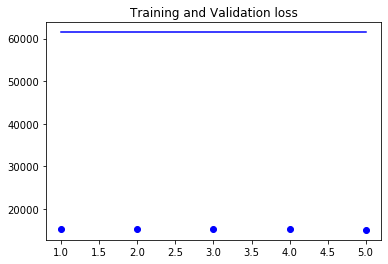

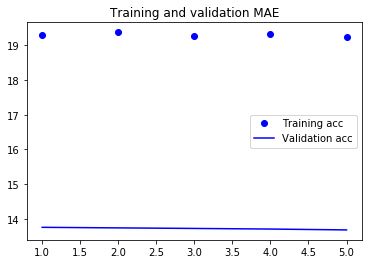

In [27]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
# plt.legend()
plt.show()

plt.clf() #清空图表

acc_values = history.history['mae']
val_acc_values  = history.history['val_mae']

plt.plot(epochs,acc_values,'bo',label='Training acc') #bo是蓝色圆点
plt.plot(epochs,val_acc_values,'b',label='Validation acc') #b是蓝色实线
plt.title('Training and validation MAE')
plt.legend()
plt.show()
